In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 35.3 MB/s eta 0:00:0000:01:00:01


In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from sklearn.preprocessing import FunctionTransformer
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [3]:
df = pd.read_csv('/kaggle/input/csv-data/data_fp.csv')
df.head()

,IC50,SMILES,bit_id_0,bit_id_1,bit_id_2,bit_id_3,bit_id_4,bit_id_5,bit_id_6,bit_id_7,...,bit_id_2038,bit_id_2039,bit_id_2040,bit_id_2041,bit_id_2042,bit_id_2043,bit_id_2044,bit_id_2045,bit_id_2046,bit_id_2047
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Вычислим значение pIC50:

image.png

In [4]:
df['pIC50'] = -np.log10(df['IC50'])
df.head()

,IC50,SMILES,bit_id_0,bit_id_1,bit_id_2,bit_id_3,bit_id_4,bit_id_5,bit_id_6,bit_id_7,...,bit_id_2039,bit_id_2040,bit_id_2041,bit_id_2042,bit_id_2043,bit_id_2044,bit_id_2045,bit_id_2046,bit_id_2047,pIC50
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.838632
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.798603
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.476254
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.492144
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.381952


Теперь посмотрим, как распределены значения pIC50

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([-3.5029185 , -3.50121765, -3.49951681, ...,  4.99790315,
         4.999604  ,  5.00130484]),
 <BarContainer object of 5000 artists>)

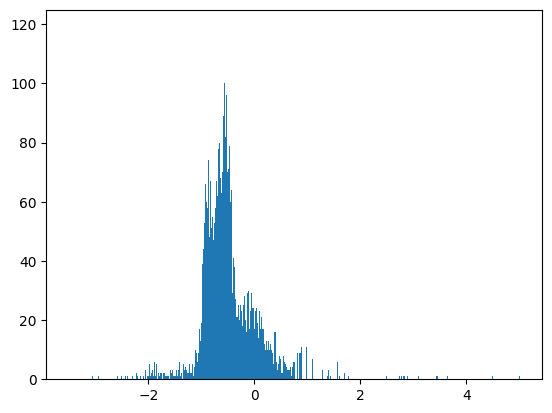

In [5]:
plt.hist(df['pIC50'], bins=5000)

In [6]:
mean = df['pIC50'].mean()
std = df['pIC50'].std()

print('среднее значение: ', mean)
print('стандартное отклонение: ', std)

среднее значение:  -0.45157586501862673
стандартное отклонение:  0.6084189179769062


Посмотрим распрделение по длине молекулы и, если необходимо, избавимся от выбросов.

array([[<Axes: title={'center': '0'}>]], dtype=object)

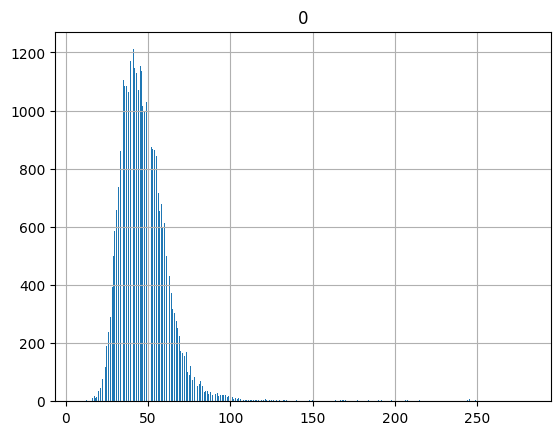

In [7]:
smiles_len = pd.DataFrame([len(sm) for sm in df["SMILES"]])
smiles_len.hist(bins=500)

In [8]:
np.percentile(smiles_len, 99)

99.0

In [9]:
len(df[df["SMILES"].apply(lambda x: len(x) > 99)])

362

In [10]:
df = df[df["SMILES"].apply(lambda x: len(x) < 100)]

Удалим все SMILES, у которых существуют пары значений pIC50, отличающихся друг от друга более, чем на значение std.

In [11]:
smiles_to_drop = set()
smiles_dict = dict()
for i in range(len(df)):
  mol = df.iloc[i]['SMILES']
  if mol in smiles_dict:
    smiles_dict[mol].append(df.iloc[i]['pIC50'])
  else:
    smiles_dict[mol] = [df.iloc[i]['pIC50']]

for smile in smiles_dict:
  arr = smiles_dict[smile]
  for i in range(len(arr) - 1):
    for j in range(i, len(arr)):
      if abs(arr[i] - arr[j]) > std:
        smiles_to_drop.add(smile)
        break

print(len(smiles_to_drop))
smiles_to_drop

35


{'C1C=C(C)[C@@H](O)[C@@H]([C@@H]12)O[C@@H](C[C@@]2(C)O)c3ccco3',
 'C1C=C(C)[C@@H](O)[C@@H]([C@@H]12)O[C@@H](C[C@]2(F)C)c3c(OC)cc(OC)cc3OC',
 'C1C=C(C)[C@@H](O)[C@@H]([C@@H]12)O[C@@H](C[C@]2(F)C)c3ccc(cc3)OC',
 'C1CN(C)CCN1CCCN2c(cccc3)c3Sc(c24)ccc(Cl)c4',
 'C1COCCN1CC(=O)O[C@H]2C[C@H](CC3)C(C)(C)[C@@]23C',
 'C1C[C@H](C2)C(C)(C)C(=O)[C@@]12C',
 'CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C(=O)O)OC(CC)CC',
 'CC(=O)N[C@H]([C@H](C1)N)[C@H](OC(CC)CC)C=C1C(=O)OCC',
 'CC(=O)N[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C',
 'CC(=O)Nc(c1)ccc(c12)oc(n2)-c(ccn3)cc3C(=O)N4CCN(CC4)[C@@H](c5nnn(n5)C)c6ccc(F)cc6',
 'CC(=O)Nc(c1)ccc(c12)oc(n2)-c(ccn3)cc3C(=O)N4CCN(CC4)[C@H](c5nnn(n5)C)c6ccccc6',
 'CC1(C)[C@@H](CC2)CC(\\[C@]12C)=N/CCCCCCC\\N=C(\\[C@@]34C)C[C@H](C3(C)C)CC4',
 'CC1(C)[C@H](CC2)CC(\\[C@@]12C)=N/CCOC(=O)CCC(=O)OCC\\N=C(\\[C@]34C)C[C@@H](C3(C)C)CC4',
 'CCCC[C@H](NC(=O)C)[C@@H]([C@@H](C1)N=C(N)N)C[C@@H]1C(=O)O',
 'COc(cc1)c(OC)cc1Cc2nccc(c23)cc(OC)c(c3)OC',
 'COc(cc1)ccc1C\\N=C\\2C[C@@H](CC3)C(C)(C)[C@@]23C',
 '

In [12]:
df = df[df["SMILES"].apply(lambda x: not(x in smiles_to_drop))]

# Models

In [14]:
def train_validate_linreg(df):
    df_copy = df.copy()
    
    X = df_copy.drop(['pIC50', 'IC50', 'SMILES'], axis=1)
    y = df_copy['pIC50']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    print(f'R2: {r2}')
    
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.show()

R2: 0.16475154792743607


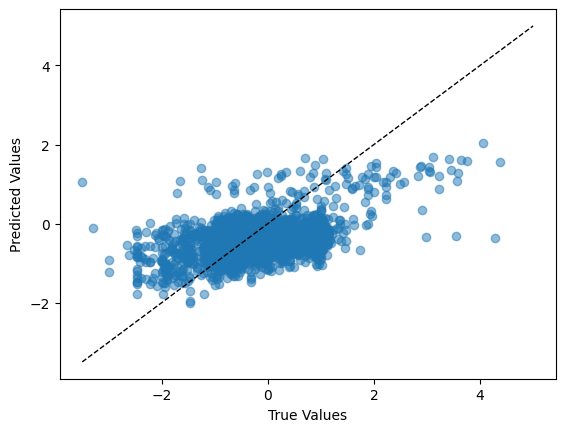

In [53]:
train_validate_linreg(df)

In [13]:
def train_validate_rf(df):
    df_copy = df.copy()
    
    X = df_copy.drop(['pIC50', 'IC50', 'SMILES'], axis=1)
    y = df_copy['pIC50']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    print(f'R2: {r2}')
    
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.show()

R2: 0.3068569295406429


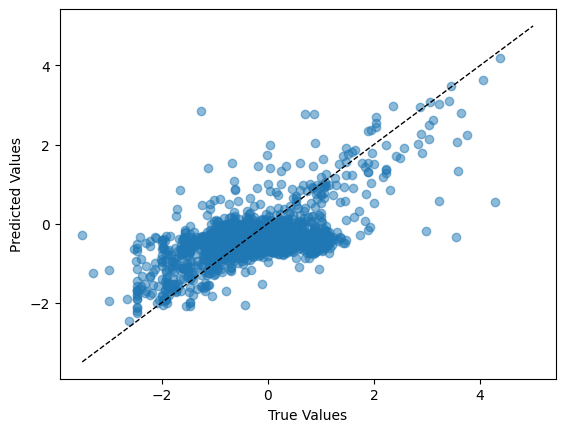

In [55]:
train_validate_rf(df)

In [14]:
def train_validate_catboost(df):
    df_copy = df.copy()
    
    X = df_copy.drop(['pIC50', 'IC50', 'SMILES'], axis=1)
    y = df_copy['pIC50']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=10, silent=True, random_state=42)
    catboost_model.fit(X_train, y_train)
    
    y_pred = catboost_model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    print(f'R2: {r2}')
    
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.show()

R2: 0.32381839075492647


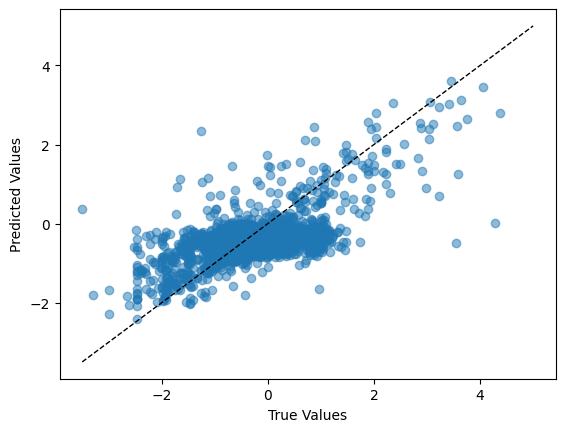

In [58]:
train_validate_catboost(df)

In [18]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(2048, 4096)
        self.bn1 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 1)
        self.double()

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

def train_validate_model(df):
    df_copy = df.copy()
    
    X = df_copy.drop(['pIC50', 'IC50', 'SMILES'], axis=1).values
    y = df_copy['pIC50'].values.reshape(-1, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_train_tensor = torch.tensor(X_train.astype(np.double))
    y_train_tensor = torch.tensor(y_train.astype(np.double))
    X_test_tensor = torch.tensor(X_test.astype(np.double))
    y_test_tensor = torch.tensor(y_test.astype(np.double))

    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
    
    model = Model()
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    
    epochs = 100
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy()
    
    r2 = r2_score(y_test, y_pred)
    print(f'R2: {r2}')
    
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.show()

R2: 0.13053294006613925


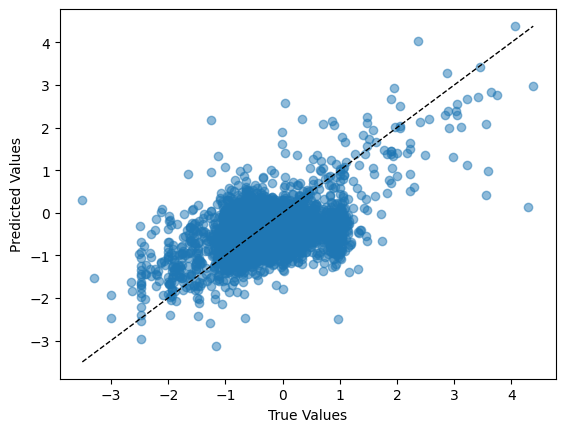

In [19]:
train_validate_model(df)

In [17]:
class SMILESDataset(Dataset):
    def __init__(self, smiles, targets, vocab=None):
        self.smiles = smiles
        self.targets = targets
        self.vocab = vocab or self.build_vocab(smiles)
        self.char_to_index = {char: i for i, char in enumerate(self.vocab)}
        self.max_len = max(map(len, smiles))

    def build_vocab(self, smiles):
        vocab = set(char for smile in smiles for char in smile)
        vocab.add('<PAD>')
        return sorted(vocab)
    
    def smiles_to_seq(self, smile):
        encoded = [self.char_to_index[char] for char in smile]
        encoded += [self.char_to_index['<PAD>']] * (self.max_len - len(smile))
        return encoded

    def __len__(self):
        return len(self.smiles)
    
    def __getitem__(self, idx):
        smile_seq = self.smiles_to_seq(self.smiles[idx])
        target = self.targets[idx]
        return torch.tensor(smile_seq, dtype=torch.long), torch.tensor(target, dtype=torch.float)

class LSTMRegressor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMRegressor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        out = self.fc(hidden[-1])
        return out

def train_validate_lstm(df):
    smiles = df['SMILES'].values
    y = df['pIC50'].values
    
    smiles_train, smiles_test, y_train, y_test = train_test_split(smiles, y, test_size=0.2, random_state=42)
    
    train_dataset = SMILESDataset(smiles_train, y_train)
    test_dataset = SMILESDataset(smiles_test, y_test, vocab=train_dataset.vocab)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    model = LSTMRegressor(vocab_size=len(train_dataset.vocab), embedding_dim=64, hidden_dim=128)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 100
    for epoch in range(epochs):
        model.train()
        for sequences, targets in train_loader:
            optimizer.zero_grad()
            predictions = model(sequences)
            loss = criterion(predictions.squeeze(), targets)
            loss.backward()
            optimizer.step()
    
    model.eval()
    y_pred = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            predictions = model(sequences).squeeze().numpy()
            y_pred.extend(predictions)
    
    r2 = r2_score(y_test, y_pred)
    print(f'R2: {r2}')
    
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.show()

R2: 0.03260401120637457


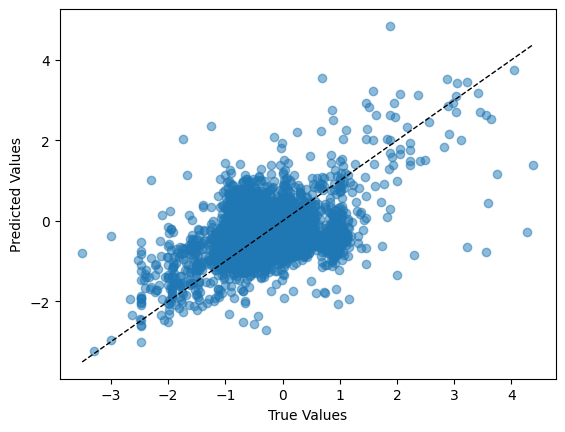

In [18]:
train_validate_lstm(df)

In [18]:
class GRURegressor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(GRURegressor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.gru(embedded)
        out = self.fc(hidden[-1])
        return out

def train_validate_gru(df):
    smiles = df['SMILES'].values
    y = df['pIC50'].values
    
    smiles_train, smiles_test, y_train, y_test = train_test_split(smiles, y, test_size=0.2, random_state=42)
    
    train_dataset = SMILESDataset(smiles_train, y_train)
    test_dataset = SMILESDataset(smiles_test, y_test, vocab=train_dataset.vocab)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    model = GRURegressor(vocab_size=len(train_dataset.vocab), embedding_dim=64, hidden_dim=128)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 100
    for epoch in range(epochs):
        model.train()
        for sequences, targets in train_loader:
            optimizer.zero_grad()
            predictions = model(sequences)
            loss = criterion(predictions.squeeze(), targets)
            loss.backward()
            optimizer.step()
    
    model.eval()
    y_pred = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            predictions = model(sequences).squeeze().numpy()
            y_pred.extend(predictions)
    
    r2 = r2_score(y_test, y_pred)
    print(f'R2: {r2}')
    
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.show()

R2: 0.07750015597359605


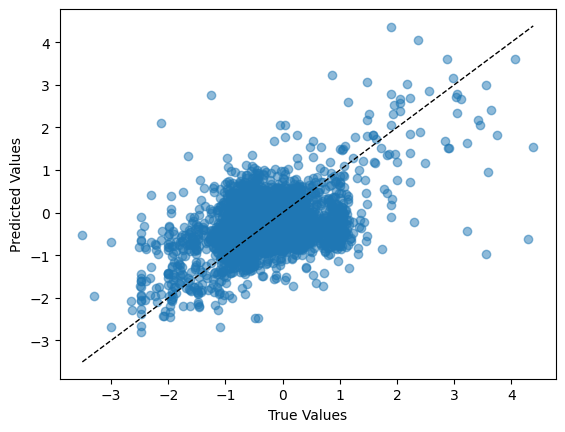

In [19]:
train_validate_gru(df)

# Метод главных компонент

In [15]:
from sklearn.decomposition import PCA

saved_columns = df[['pIC50', 'IC50', 'SMILES']].copy()
X = df.drop(['IC50', 'pIC50', 'SMILES'], axis=1)

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

In [16]:
X_reduced_df = pd.DataFrame(X_reduced, columns=[f'PC{i+1}' for i in range(X_reduced.shape[1])])
X_reduced_df = pd.concat([saved_columns, X_reduced_df], axis=1)
X_reduced_df = X_reduced_df.dropna()
X_reduced_df.head()

,pIC50,IC50,SMILES,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC1562,PC1563,PC1564,PC1565,PC1566,PC1567,PC1568,PC1569,PC1570,PC1571
0,4.838632,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,1.251001,0.869257,-0.648869,0.310060,-1.910766,-1.799151,-0.131092,...,-0.006249,-0.149162,0.016314,-0.017021,0.062514,-0.015855,0.138802,0.014344,-0.029113,-0.059085
1,4.798603,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,0.951611,0.718674,-0.510423,0.475712,-1.941085,-1.779481,-0.095526,...,-0.084724,0.163837,-0.034032,-0.073006,0.077727,-0.132890,0.015269,-0.101485,-0.045697,-0.031174
2,4.476254,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,0.781840,1.153079,-0.433804,0.343838,-1.482232,-1.523074,-0.044641,...,0.096910,0.066026,0.104005,-0.028645,-0.097385,-0.040930,0.013831,-0.080518,-0.153856,0.099264
3,4.492144,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,0.923489,1.262190,-0.541264,0.458055,-1.636457,-1.836669,-0.108065,...,-0.107831,0.087453,0.058312,0.025708,-0.033250,0.046209,-0.041315,-0.072956,-0.026232,0.056297
4,4.381952,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,-0.113287,-0.096440,0.267919,-0.722960,-0.312287,-0.423158,-0.381054,...,0.111024,0.009429,0.102829,0.048908,0.062577,-0.184608,0.009408,0.138483,-0.033829,-0.099214


R2: 0.1879219878231937


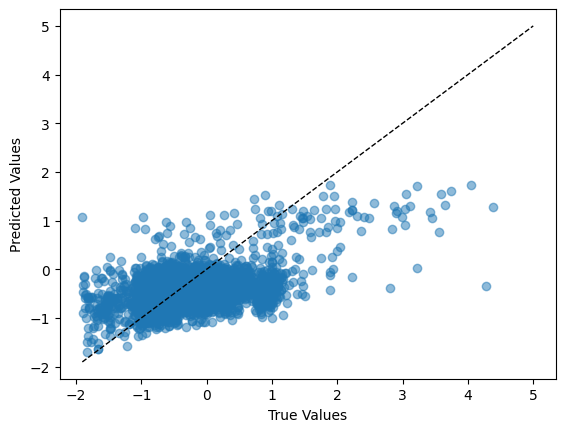

In [21]:
train_validate_linreg(X_reduced_df)

R2: 0.24717370649010495


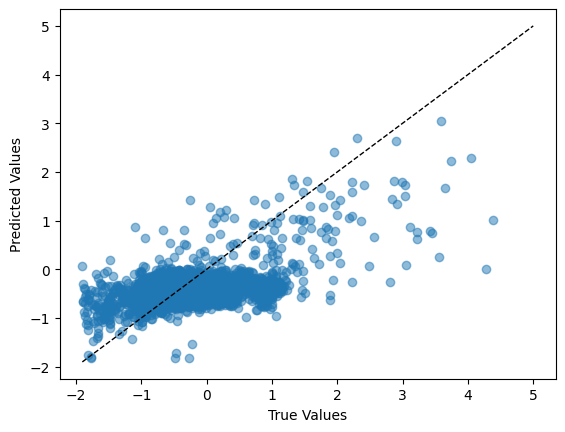

In [19]:
train_validate_catboost(X_reduced_df)